# Install and import the requirements

In [1]:
import pandas as pd

import json

import re

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install spacy
import spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 862.8 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Upload data

*  'mushroom.en-val.v2.jsonl' - original data from organizers
*  'en_val_new1.jsonl' - the results from our model

In [12]:
from google.colab import files
files = files.upload()

Saving en_val_new1.jsonl to en_val_new1.jsonl


In [4]:
def load_jsonl_file_to_records(filename):
    records = []
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                records.append(json.loads(line))

        return pd.DataFrame(records)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None

In [25]:
df = load_jsonl_file_to_records('mushroom.en-val.v2.jsonl')
#df = load_jsonl_file_to_records('en_val_new1.jsonl')
print("Length of the validation data:", len(df))
df.head()

Length of the validation data: 50


,id,lang,model_input,model_output_text,model_id,soft_labels,hard_labels,model_output_logits,model_output_tokens
0,val-en-1,EN,What did Petra van Staveren win a gold medal for?,Petra van Stoveren won a silver medal in the 2...,tiiuae/falcon-7b-instruct,"[{'start': 10, 'prob': 0.2, 'end': 12}, {'star...","[[25, 31], [45, 49], [69, 83]]","[-5.5669536591, -11.90533638, -13.0743436813, ...","[Pet, ra, Ġvan, ĠSto, ve, ren, Ġwon, Ġa, Ġsilv..."
1,val-en-2,EN,How many genera does the Erysiphales order con...,The Elysiphale order contains 5 genera.,tiiuae/falcon-7b-instruct,"[{'start': 4, 'prob': 0.2, 'end': 14}, {'start...","[[30, 31]]","[-6.199614048, -13.7564926147, -14.0058326721,...","[The, ĠE, lys, iph, ale, Ġorder, Ġcontains, Ġ,..."
2,val-en-3,EN,Do all arthropods have antennae?,"Yes, all arachnids have antennas. However, not...",tiiuae/falcon-7b-instruct,"[{'start': 0, 'prob': 0.6, 'end': 3}, {'start'...","[[0, 3], [9, 18], [63, 70], [78, 87]]","[-4.8190689087, -16.5279369354, -10.1344690323...","[Yes, ,, Ġall, Ġar, ach, n, ids, Ġhave, Ġanten..."
3,val-en-4,EN,When did Chance the Rapper debut?,Chance the rapper debuted in 2011.,tiiuae/falcon-7b-instruct,"[{'start': 18, 'prob': 0.0909090909, 'end': 29...","[[29, 33]]","[-6.2555613518, -10.9392805099, -13.1335763931...","[Ch, ance, Ġthe, Ġrapper, Ġdebuted, Ġin, Ġ, 20..."
4,val-en-5,EN,What is the UN Sustainable Development Goal 11...,The UN's Sustainable City initiative defines a...,tiiuae/falcon-7b-instruct,"[{'start': 0, 'prob': 0.0909090909, 'end': 9},...","[[70, 227]]","[-3.9737114906, -12.9197320938, -7.2846975327,...","[The, ĠUN, ', s, ĠSustainable, ĠCity, Ġinitiat..."


# POS statistics with 'en_core_web_lg' from spacy

## Get list of hallucinated strings using hard labels (SKIP this cell if 'hallucinated_words' is already present)

In [26]:
def get_hallucinated_text(text, hard_labels):
    """
    text: string,
    hard_labels: list of lists

    Returns list of hallucinated strings.
    """
    hallucinated_text = []

    if len(hard_labels) > 0:
        for i in range(len(hard_labels)):
            hallucinated_text.append(text[hard_labels[i][0]: hard_labels[i][1]])

    return hallucinated_text

df["hallucinated_words"] = df.apply(lambda x: get_hallucinated_text(x["model_output_text"], x["hard_labels"]), axis=1)
df.head()

,id,lang,model_input,model_output_text,model_id,soft_labels,hard_labels,model_output_logits,model_output_tokens,hallucinated_words
0,val-en-1,EN,What did Petra van Staveren win a gold medal for?,Petra van Stoveren won a silver medal in the 2...,tiiuae/falcon-7b-instruct,"[{'start': 10, 'prob': 0.2, 'end': 12}, {'star...","[[25, 31], [45, 49], [69, 83]]","[-5.5669536591, -11.90533638, -13.0743436813, ...","[Pet, ra, Ġvan, ĠSto, ve, ren, Ġwon, Ġa, Ġsilv...","[silver, 2008, Beijing, China]"
1,val-en-2,EN,How many genera does the Erysiphales order con...,The Elysiphale order contains 5 genera.,tiiuae/falcon-7b-instruct,"[{'start': 4, 'prob': 0.2, 'end': 14}, {'start...","[[30, 31]]","[-6.199614048, -13.7564926147, -14.0058326721,...","[The, ĠE, lys, iph, ale, Ġorder, Ġcontains, Ġ,...",[5]
2,val-en-3,EN,Do all arthropods have antennae?,"Yes, all arachnids have antennas. However, not...",tiiuae/falcon-7b-instruct,"[{'start': 0, 'prob': 0.6, 'end': 3}, {'start'...","[[0, 3], [9, 18], [63, 70], [78, 87]]","[-4.8190689087, -16.5279369354, -10.1344690323...","[Yes, ,, Ġall, Ġar, ach, n, ids, Ġhave, Ġanten...","[Yes, arachnids, visible, naked eye]"
3,val-en-4,EN,When did Chance the Rapper debut?,Chance the rapper debuted in 2011.,tiiuae/falcon-7b-instruct,"[{'start': 18, 'prob': 0.0909090909, 'end': 29...","[[29, 33]]","[-6.2555613518, -10.9392805099, -13.1335763931...","[Ch, ance, Ġthe, Ġrapper, Ġdebuted, Ġin, Ġ, 20...",[2011]
4,val-en-5,EN,What is the UN Sustainable Development Goal 11...,The UN's Sustainable City initiative defines a...,tiiuae/falcon-7b-instruct,"[{'start': 0, 'prob': 0.0909090909, 'end': 9},...","[[70, 227]]","[-3.9737114906, -12.9197320938, -7.2846975327,...","[The, ĠUN, ', s, ĠSustainable, ĠCity, Ġinitiat...",[Equipped with infrastructure and services to ...


## Count parts of speech and tags for each token in 'hallucinated_text'

In [27]:
nlp = spacy.load("en_core_web_lg")

pos_c = Counter()
tag_c = Counter()

pos_full_dict, tag_full_dict = {}, {}

for index, row in df.iterrows():
   hal_text = " ".join(row["hallucinated_words"])
   doc = nlp(hal_text)
   for token in doc:
      # Update counters
      pos_c[token.pos_] += 1
      tag_c[token.tag_] += 1
      # Add tokens to full dictionaries with examples for each POS and tag
      if token.pos_ not in pos_full_dict.keys():
         pos_full_dict[token.pos_] = [token]
      else:
         pos_full_dict[token.pos_].append(token)

      if token.tag_ not in tag_full_dict.keys():
         tag_full_dict[token.tag_] = [token]
      else:
         tag_full_dict[token.tag_].append(token)

print(pos_c.most_common())
print()
print(tag_c.most_common())
print()
print(pos_full_dict)
print()
print(tag_full_dict)

[('PROPN', 100), ('NOUN', 95), ('NUM', 46), ('ADP', 41), ('ADJ', 39), ('PUNCT', 33), ('VERB', 33), ('DET', 30), ('CCONJ', 15), ('PART', 15), ('PRON', 14), ('AUX', 12), ('ADV', 11), ('INTJ', 2), ('SCONJ', 2), ('SYM', 2), ('SPACE', 1)]

[('NNP', 96), ('NN', 68), ('CD', 46), ('IN', 42), ('JJ', 35), ('DT', 31), ('NNS', 27), (',', 20), ('RB', 19), ('CC', 15), ('VBN', 13), ('VBD', 9), ('VBZ', 8), ('PRP', 7), ('VB', 6), ('VBP', 5), ('VBG', 4), ('PRP$', 4), ('HYPH', 4), ('NNPS', 4), ('-LRB-', 4), ('TO', 3), ('POS', 3), ('.', 3), ('UH', 2), ('JJS', 2), ('JJR', 2), ('SYM', 2), (':', 2), ('RBR', 1), ('WDT', 1), ('_SP', 1), ('RP', 1), ('EX', 1)]

{'NOUN': [silver, arachnids, eye, infrastructure, services, access, range, services, water, sanitation, electricity, rice, seafood, vegetables, meat, pork, 13th, Puncher, labour, stage, labour, phase, transition, delivery, 1950s, amount, data, image, pirate, parrot, shoulder, origin, evidence, brand, introduction, city, region, machine, building, hand, co

<ipython-input-28-959be58aa443>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(pos_lst, rotation=45)
<ipython-input-28-959be58aa443>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(tag_lst, rotation=60)


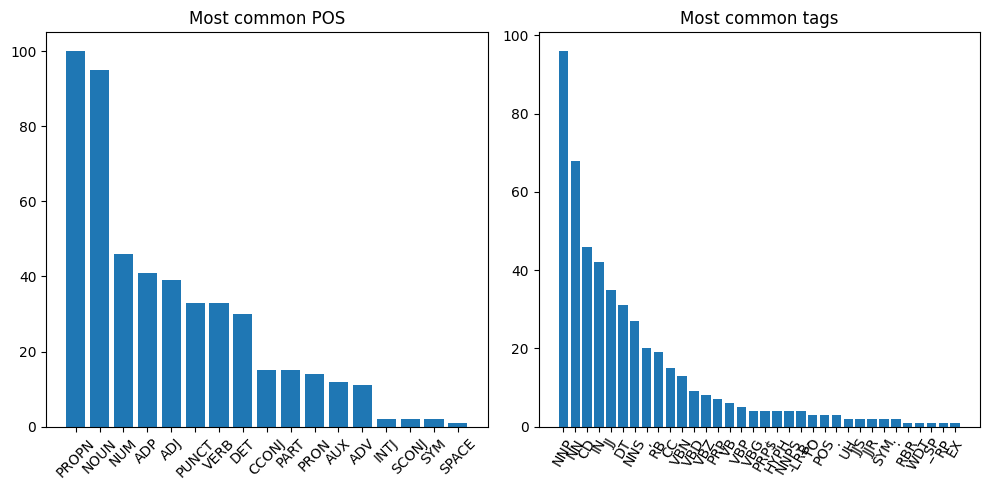

In [28]:
pos_lst = [key for key, _ in pos_c.most_common()]
pos_count_lst = [value for _, value in pos_c.most_common()]

tag_lst = [key for key, _ in tag_c.most_common()]
tag_count_lst = [value for _, value in tag_c.most_common()]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].bar(pos_lst, pos_count_lst)
axes[0].set_title('Most common POS')
axes[0].set_xticklabels(pos_lst, rotation=45)

axes[1].bar(tag_lst, tag_count_lst)
axes[1].set_title('Most common tags')
axes[1].set_xticklabels(tag_lst, rotation=60)

plt.tight_layout()
plt.show()

## Print a couple of examples for each POS and tag

In [29]:
print("Examples of most common POS")
for pos in pos_lst:
    try:
        print(pos, ":", pos_full_dict[pos][:3])
    except:
        print(pos, ":", pos_full_dict[pos])
print()

print("Examples of most common tags")
for tag in tag_lst:
    try:
        print(tag, ":", tag_full_dict[tag][:3])
    except:
        print(tag, ":", tag_full_dict[tag])

Examples of most common POS
PROPN : [Beijing, China, Jiangnan]
NOUN : [silver, arachnids, eye]
NUM : [2008, 5, 2011]
ADP : [with, to, of]
ADJ : [naked, sustainable, equitable]
PUNCT : [,, ,, ,]
VERB : [visible, Equipped, ensure]
DET : [a, the, the]
CCONJ : [and, and, and]
PART : [to, 's, not]
PRON : [his, It, his]
AUX : [did, suggest, was]
ADV : [exactly, well, third]
INTJ : [Yes, Zack]
SCONJ : [until, while]
SYM : [-, -]
SPACE : [

]

Examples of most common tags
NNP : [Beijing, China, Jiangnan]
NN : [silver, eye, infrastructure]
CD : [2008, 5, 2011]
IN : [with, to, of]
JJ : [naked, sustainable, equitable]
DT : [a, the, the]
NNS : [arachnids, services, services]
, : [,, ,, ,]
RB : [not, exactly, not]
CC : [and, and, and]
VBN : [Equipped, documented, invented]
VBD : [did, was, was]
VBZ : [is, includes, includes]
PRP : [It, It, it]
VB : [ensure, appear, suggest]
VBP : [visible, have, have]
VBG : [Bleaching, reducing, making]
PRP$ : [his, his, its]
HYPH : [-, -, -]
NNPS : [Detinets, Semi

# Named Entities

## Count named entities for each datapoint in 'hallucinated_text'

In [30]:
ent_label_c = Counter()

full_ent_dict = {}

for index, row in df.iterrows():
    hal_text = " ".join(row["hallucinated_words"])
    doc = nlp(hal_text)
    for ent in doc.ents:
        entity = ent.text
        ent_label = ent.label_

        if ent_label not in full_ent_dict.keys():
            full_ent_dict[ent_label] = [entity]
        else:
            full_ent_dict[ent_label].append(entity)

        ent_label_c[ent_label] += 1

print(ent_label_c.most_common())
print()
print(full_ent_dict)

[('DATE', 19), ('GPE', 12), ('CARDINAL', 12), ('PERSON', 12), ('QUANTITY', 6), ('NORP', 5), ('ORG', 5), ('PRODUCT', 5), ('FAC', 4), ('ORDINAL', 4), ('LANGUAGE', 1), ('LOC', 1), ('EVENT', 1), ('PERCENT', 1)]

{'DATE': ['2008', '2011', '2021 1.5 million', '2005', '1960', 'February 23 March 5, 2013', '2001', '1945', '1954', 'the late 13th century', '1878', '2004', 'now no year', 'mid-1800s', '1885', 'January 2007', 'March 1, 2011 88', 'early Middle Ages', 'March 4, 1786'], 'GPE': ['Beijing', 'China', 'Jiangnan', 'Xiamen', 'Rasnov', 'Romania', 'Yekaterinburg', 'Moscow', 'Switzerland', 'Minsk', 'Belarus', 'Tampa'], 'CARDINAL': ['5', '162', 'one', 'one', 'one', 'one', '1845', '1260 1524', '12', '1625', '5', '43'], 'FAC': ['Zhaozhou', 'Foxboro Stadium', 'the Moscow Kremlin', 'the Cathedral Square'], 'LANGUAGE': ['Cantonese'], 'ORDINAL': ['13th', 'third', 'first', 'first'], 'NORP': ['English', 'Detinets', 'Native American', 'Seminoles', 'European'], 'PERSON': ['John Latham', 'Michael Cathedral

## Print a couple of examples for each named entity label

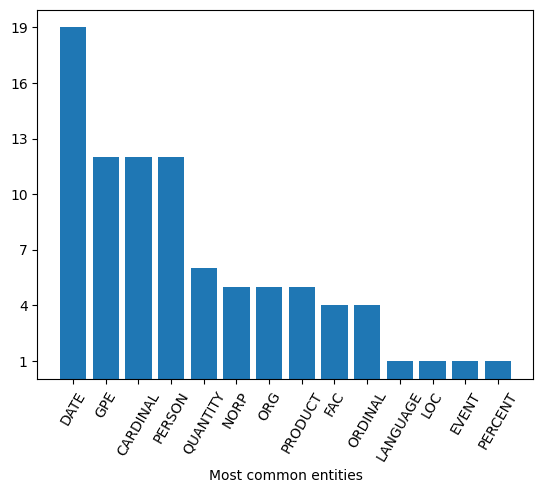

In [31]:
ent_lst = [key for key, _ in ent_label_c.most_common()]
ent_count_lst = [value for _, value in ent_label_c.most_common()]

plt.bar(ent_lst, ent_count_lst)
plt.xticks(rotation=60)
plt.xlabel('Most common entities')
plt.yticks(np.arange(min(ent_count_lst), max(ent_count_lst) + 1, 3))

plt.show()

In [21]:
full_ent_dict = dict(sorted(full_ent_dict.items(), key=lambda item: len(item[1]), reverse=True))

for key in full_ent_dict.keys():
    try:
        print(key, ":", full_ent_dict[key][:3])
    except:
        print(key, ":", full_ent_dict[key])

DATE : ['2008', '2011', 'tomo 2005']
CARDINAL : ['5', 'zhaozhou', '162']
PERSON : ['jiangnan zhejing', 'toyo', 'mamé cillerulo']
GPE : ['china', 'beijing', 'salzberg']
ORG : ['xiamen', 'foxboro', 'united diageo']
ORDINAL : ['13th', 'third', 'first']
NORP : ['rasnov', 'mmu']
